In [53]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pylab import rcParams
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import MinMaxScaler
from sklearn import preprocessing

# 1. Выбор набора данных

### 1.1. Дерматология (35)

In [320]:
data = pd.read_csv('dermatology.data')
data.head(3)

,erythema,scaling,definite borders,itching,koebner phenomenon,polygonal papules,follicular papules,oral mucosal involvement,knee and elbow involvement,scalp involvement,...,munro microabcess,focal hypergranulosis,disappearance of the granular layer,vacuolisation and damage of basal layer,spongiosis,saw-tooth appearance of retes,follicular horn plug,perifollicular parakeratosis,inflammatory monoluclear inflitrate,band-like infiltrate
0,2,2,0,3,0,0,0,0,1,0,...,0,0,3,0,0,0,1,0,55,2
1,3,3,3,2,1,0,0,0,1,1,...,0,0,0,0,0,0,1,0,8,1
2,2,1,2,3,1,3,0,3,0,0,...,0,2,3,2,0,0,2,3,26,3


In [321]:
#Выделяем признак, по которому будем классифицировать объекты
target_feature='spongiosis'
target = data[target_feature]
data = data.drop([target_feature], axis=1)
X = data.iloc[:,:].values

### 1.2. Вино (13)

In [332]:
data = pd.read_csv('wine-clustering.csv')
X = data.iloc[:,:].values
data.head(3)

,Alcohol,Malic_Acid,Ash,Ash_Alcanity,Magnesium,Total_Phenols,Flavanoids,Nonflavanoid_Phenols,Proanthocyanins,Color_Intensity,Hue,OD280,Proline
0,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185


### 1.3. Шахматы (16)

In [336]:
data = pd.read_csv('games.csv')

In [296]:
data = data.iloc[:5000,:]

In [297]:
#Выделяем признак, по которому будем классифицировать объекты
target_feature='winner'
#И признаки, которые не будем учитывать
columns_to_drop=[target_feature,'id','moves','opening_name']

In [298]:
category_data_columns = ["victory_status", "winner", "increment_code", "white_id", "black_id","opening_eco"]

category_data = data[category_data_columns]

# Кодирование категориальных признаков
enc = preprocessing.OrdinalEncoder()
enc.fit(category_data)

category_data = pd.DataFrame(list(enc.transform(category_data)), columns=category_data_columns)

In [299]:
for column in category_data_columns:
    data[column] = category_data[column]
    
target = data[target_feature]
data = data.drop(columns_to_drop, axis=1)

In [300]:
scaler = MinMaxScaler()

scaler.fit(data)
data = pd.DataFrame(scaler.transform(data),columns=data.columns)
X = data.iloc[:,:].values

### 1.4. Валюта (2)

In [340]:
data = pd.read_csv('currency.csv')

In [341]:
def processDate(x):
    temp_date = x.split('/')
    if len(temp_date) < 3:
        return x
    return str(int(temp_date[0]) * 31 + ((int(temp_date[2])) - 17) * 365 + int(temp_date[1]))

data['Time'] = data['Time'].apply(processDate)

In [342]:
scaler = MinMaxScaler()

scaler.fit(data[['Time']])
data['Time'] = scaler.transform(data[['Time']])

scaler.fit(data[['Gems']])
data['Gems'] = scaler.transform(data[['Gems']])

In [343]:
X = data.iloc[:,:].values
data.head(5)

,Time,Gems
0,0.000000,0.246008
1,0.003390,0.189194
2,0.006780,0.019622
3,0.010169,0.119464
4,0.013559,0.096274


### 1.5. Случайные смерти (2)

In [115]:
data = pd.read_csv('accidental-deaths-in-usa-monthly.csv')

In [116]:
def processDate(x):
    temp_date = x.split('-')
    if len(temp_date) < 2:
        return x
    return str((int(temp_date[0]) - 1973) * 12 + int(temp_date[1]))

data['Month'] = data['Month'].apply(processDate)

In [117]:
scaler = MinMaxScaler()

scaler.fit(data[['Month']])
data['Month'] = scaler.transform(data[['Month']])

scaler.fit(data[['Deaths']])
data['Deaths'] = scaler.transform(data[['Deaths']])

In [118]:
X = data.iloc[:,:].values
data.head(5)

,Month,Deaths
0,0.000000,0.477966
1,0.014085,0.274350
2,0.028169,0.460113
3,0.042254,0.507345
4,0.056338,0.706215


# 2. Определение переменных и функций

In [303]:
cluster_number = 2

In [23]:
def buildSilhouetteCurve(silhouette_scores, n_clusters_min, n_clusters_max):
    rcParams['figure.figsize'] = 16, 5
    plt.plot(range(n_clusters_min, n_clusters_max + 1), silhouette_scores, "bo-", color='blue',
            linewidth=3, markersize=6, label='Кривая индекса')
    plt.xlabel("$k$", fontsize=14, family='Arial')
    plt.ylabel('Значение индекса', fontsize=14, family='Arial')
    plt.grid(which='major', color='#cccccc', linestyle="--")
    plt.title('Кривая индекса кластерного силуэта', family='Arial', fontsize=14)

    #Вычисляем оптимальное значение кластеров
    k = np.argmax(silhouette_scores) + 2

    #Рисуем вертикальную линию

    plt.axvline(x=k, linestyle='--', c='green', linewidth=3,
                label='Оптимальное количество кластеров ({})'.format(k))

    plt.scatter(k, silhouette_scores[k-2], c='red', s=400)

    plt.legend(shadow=True)

    plt.show()

In [209]:
def buildClusterScatter(labels, centroids, silhouette_score, data, ax):
    
    u_labels = np.unique(labels)
    
    for j in u_labels:
        temp_data = data.values
        ax.scatter(temp_data[labels == j,0], temp_data[labels == j,1], label = j)

    ax.legend()
    if centroids is not None:
        ax.scatter(centroids[:,0] , centroids[:,1] , s = 80, color = 'k')
    ax.set_title('Индекс кластерного силуэта:' + str(round(silhouette_score,5)))

# 3. k-means

In [120]:
kmeans = KMeans(n_clusters=cluster_number, random_state=0)

In [322]:
kmeans.fit(X)

kmeans_per_k = [KMeans(n_clusters=k, random_state=42).fit(X) for k in range(2,11)]
silhouette_scores = [silhouette_score(X, model.labels_) for model in kmeans_per_k]

C:\Users\75BD~1\AppData\Local\Temp/ipykernel_11216/1067797533.py:3: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "bo-" (-> color='b'). The keyword argument will take precedence.
  plt.plot(range(n_clusters_min, n_clusters_max + 1), silhouette_scores, "bo-", color='blue',


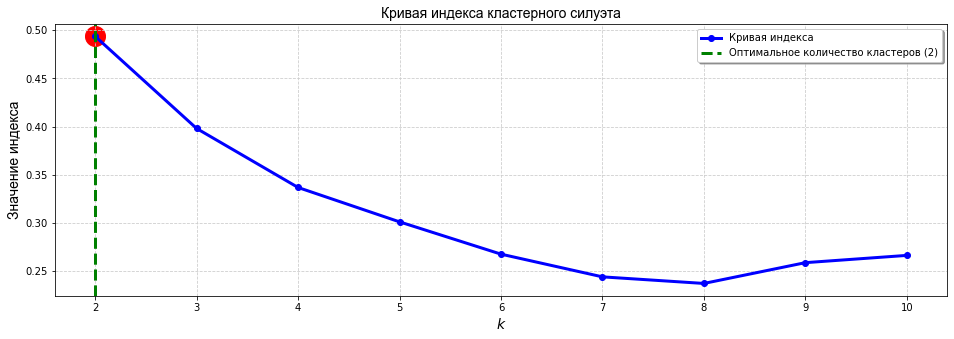

In [323]:
buildSilhouetteCurve(silhouette_scores, 2, 10)

In [102]:
import umap
from sklearn.manifold import TSNE

reducer = umap.UMAP()
tsne = TSNE(n_components=2, random_state=0)

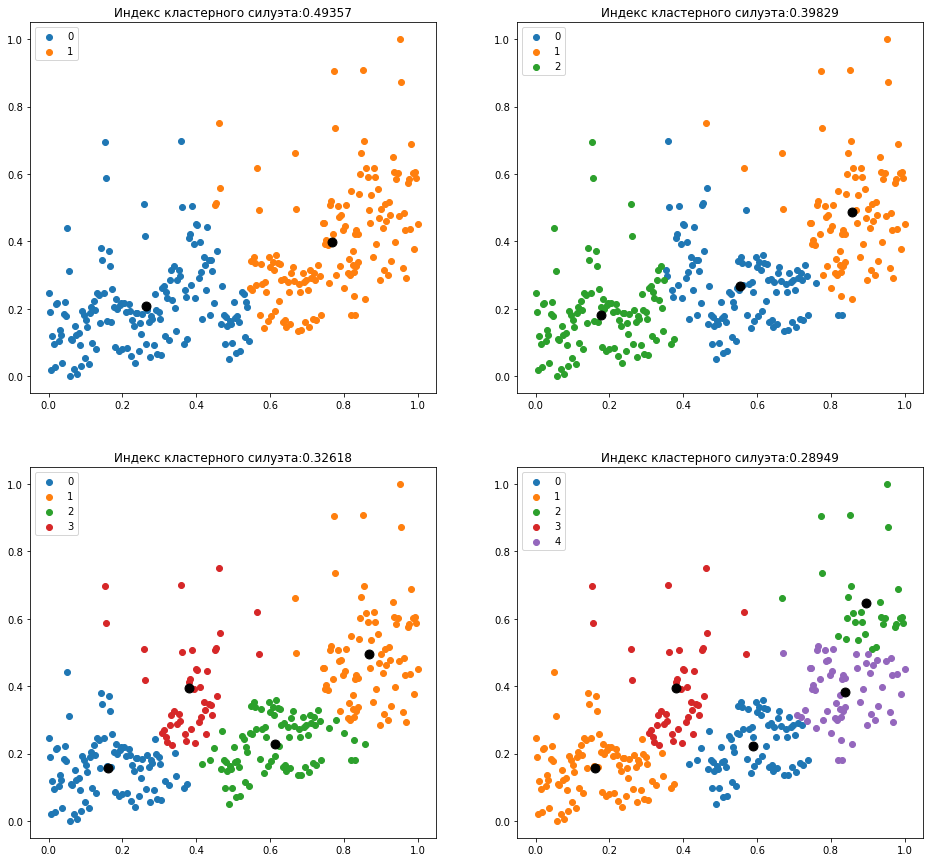

In [344]:
fig, ax = plt.subplots(2, 2, figsize=(16,15))
ax = np.ravel(ax)

# 1 - UMAP
# 2 - TSNE
reducing_method = 1

cluster_number = 2
for i in range(4):
    km = KMeans(n_clusters=cluster_number, random_state=0)   
    labels = km.fit_predict(data)
    centroids = km.cluster_centers_
    
    data_2d = data
    if data_2d.shape[1] > 2:
        if reducing_method == 1:
            data_2d = reducer.fit_transform(np.concatenate((centroids, data)))
            centroids = data_2d[:cluster_number]
            data_2d = pd.DataFrame(data_2d[cluster_number:])
        elif reducing_method == 2:
            data_2d = tsne.fit_transform(np.concatenate((centroids, data)))
            centroids = data_2d[:cluster_number]
            data_2d = pd.DataFrame(data_2d[cluster_number:])
    buildClusterScatter(labels, centroids, silhouette_scores[i], data_2d, ax[i])
    cluster_number += 1
plt.show()

In [325]:
# 1 - UMAP
# 2 - TSNE
reducing_method = 1
cluster_number = 3

km = KMeans(n_clusters=cluster_number, random_state=0)   
labels = km.fit_predict(data)
centroids = km.cluster_centers_
    
data_2d = data
if reducing_method == 1:
    data_2d = reducer.fit_transform(np.concatenate((centroids, data)))
    centroids = data_2d[:cluster_number]
    data_2d = pd.DataFrame(data_2d[cluster_number:])
elif reducing_method == 2:
    data_2d = tsne.fit_transform(np.concatenate((centroids, data)))
    centroids = data_2d[:cluster_number]
    data_2d = pd.DataFrame(data_2d[cluster_number:])

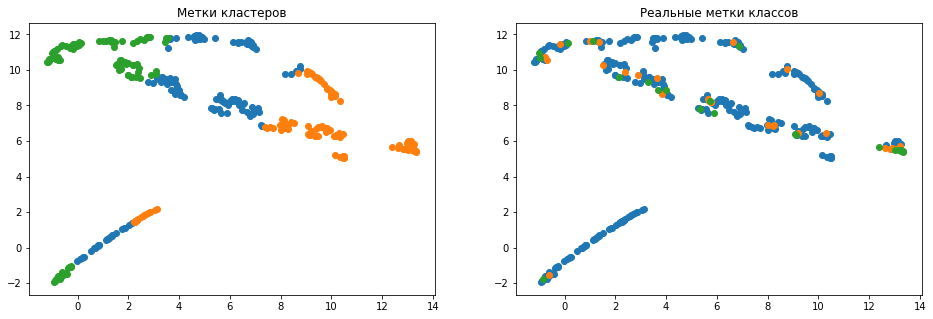

In [326]:
_, ax = plt.subplots(1,2,figsize=(16,5))

target_values = [labels,target]

titles = ["Метки кластеров", "Реальные метки классов"]
colors = ['blue','green','red','orange','yellow','cyan']
for ax_num in range(2):
    data_2d['Cluster'] = target_values[ax_num]
    for i in range(len(np.unique(data_2d['Cluster']))):
    
        temp_df = data_2d[data_2d.Cluster==i]

        ax[ax_num].scatter(temp_df[0],temp_df[1],label=i)
        ax[ax_num].set_title(titles[ax_num])
        
plt.show()

# 4. FCM

In [220]:
from fcmeans import FCM

In [327]:
silhouette_scores = []
for k in range(2,11):
    fcm = FCM(n_clusters=k)
    fcm.fit(X)
    silhouette_scores.append(silhouette_score(X, fcm.predict(X)))

C:\Users\75BD~1\AppData\Local\Temp/ipykernel_11216/1067797533.py:3: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "bo-" (-> color='b'). The keyword argument will take precedence.
  plt.plot(range(n_clusters_min, n_clusters_max + 1), silhouette_scores, "bo-", color='blue',


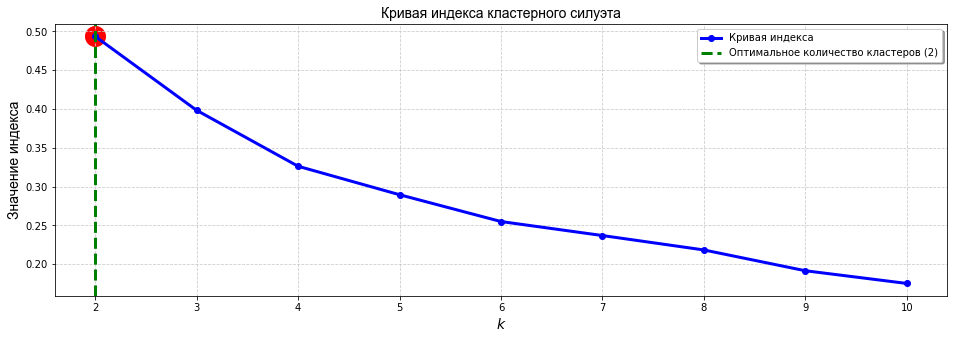

In [328]:
buildSilhouetteCurve(silhouette_scores, 2, 10)

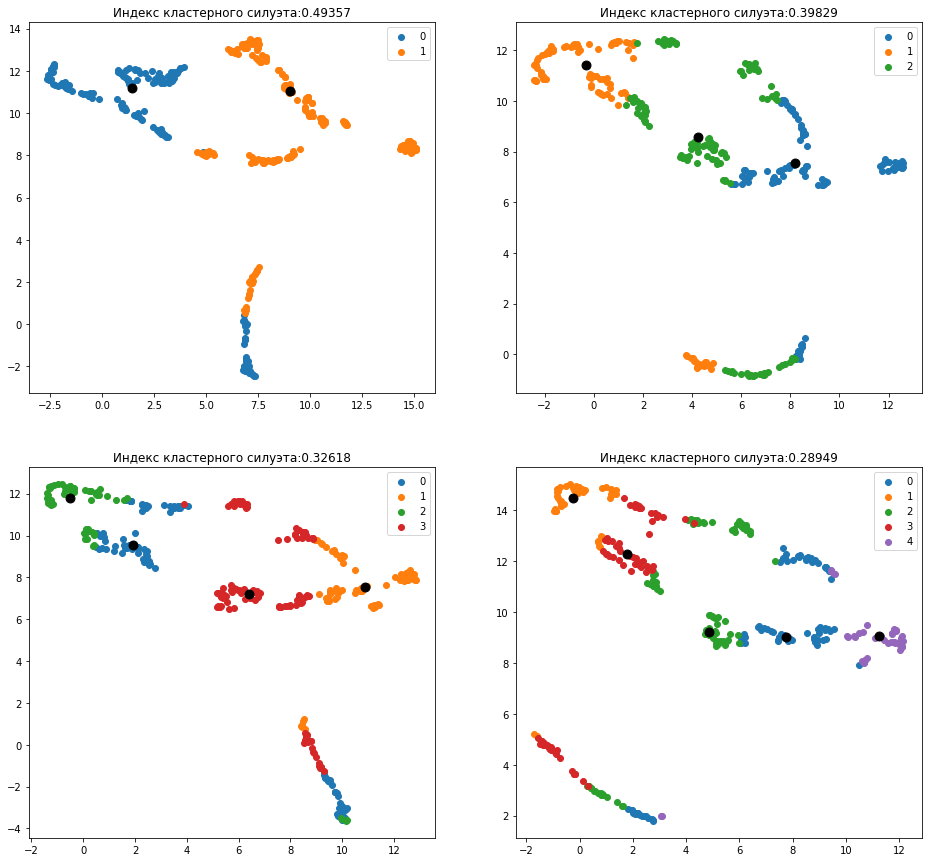

In [330]:
fig, ax = plt.subplots(2, 2, figsize=(16,15))
ax = np.ravel(ax)

# 1 - UMAP
# 2 - TSNE
reducing_method = 1

cluster_number = 2
for i in range(4):
    fcm = FCM(n_clusters=cluster_number)
    fcm.fit(data.values)
    labels = fcm.predict(data.values)
    centroids = fcm.centers
    
    data_2d = data
    if reducing_method == 1:
        data_2d = reducer.fit_transform(np.concatenate((centroids, data)))
        centroids = data_2d[:cluster_number]
        data_2d = pd.DataFrame(data_2d[cluster_number:])
    elif reducing_method == 2:
        data_2d = tsne.fit_transform(np.concatenate((centroids, data)))
        centroids = data_2d[:cluster_number]
        data_2d = pd.DataFrame(data_2d[cluster_number:])
    buildClusterScatter(labels, centroids, silhouette_scores[i], data_2d, ax[i])
    cluster_number += 1
plt.show()

In [219]:
import sys
!{sys.executable} -m pip install fuzzy-c-means

ERROR: Could not find a version that satisfies the requirement fcmeans
ERROR: No matching distribution found for fcmeans


# 5. DBSCAN

In [230]:
from sklearn.cluster import DBSCAN

Количество кластеров: 1


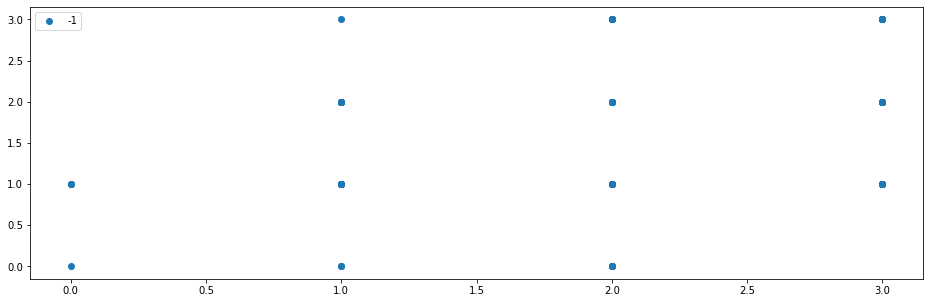

In [331]:
dbscan = DBSCAN(eps=10, min_samples=15)
labels = dbscan.fit_predict(data)
#labels = dbscan.labels_

# 1 - UMAP
# 2 - TSNE
reducing_method = 1

dbscan = DBSCAN(eps=0.05, min_samples=3)
dbscan.fit(data.values)
labels = dbscan.labels_

print('Количество кластеров:', len(np.unique(labels)))

data_2d = data
if reducing_method == 1:
    data_2d = reducer.fit_transform(data)
    data_2d = pd.DataFrame(data_2d)
elif reducing_method == 2:
    data_2d = tsne.fit_transform(data)
    data_2d = pd.DataFrame(data_2d)

u_labels = np.unique(labels)
    
for j in u_labels:
    temp_data = data.values
    plt.scatter(temp_data[labels == j,0], temp_data[labels == j,1], label = j)

plt.legend()
    
cluster_number += 1
plt.show()